## 0. Libraries and Personal Tools

In [1]:
import sys


from gc import collect
from os.path import abspath

from re import findall

from pandas import DataFrame
from pandas import read_feather, read_csv
from pandas.api.types import CategoricalDtype

from sklearn.model_selection import train_test_split

In [2]:
# add absolute path from root to sys.path to use custom modules
sys.path.insert(0, abspath('..'))

## 1. Get Train Data

In [3]:
df = read_feather(f"../data/interim/small_train_compressed.ftr")
df.set_index(["game_num", "event_id", "event_time"], inplace=True)

In [4]:
# Free some memory after loading the data
collect()

0

## 2. Get Features and Targets

In [5]:
model_features = read_csv("../data/raw/test_dtypes.csv")
FEATURES = [feature for feature in model_features.column.tolist() if feature != "id"]

In [6]:
len(FEATURES)

54

In [7]:
TEAM = "A"
TARGET = f"team_{TEAM}_scoring_within_10sec"
df[TARGET].value_counts(normalize=True, dropna=False)

0    0.941689
1    0.058311
Name: team_A_scoring_within_10sec, dtype: float64

## 3. Train and Test Split

In [8]:
from sklearn.model_selection import GroupShuffleSplit

In [9]:
gsp = GroupShuffleSplit(n_splits=2, test_size=0.3, random_state=777)
train_index, test_index = next(gsp.split(df, groups=df.index.get_level_values("game_num")))

X_train = df[FEATURES].iloc[train_index]
y_train = df[TARGET].iloc[train_index]

X_test = df[FEATURES].iloc[test_index]
y_test = df[TARGET].iloc[test_index]

In [10]:
del df

In [11]:
collect()

0

## 4. Feature Engineering

1. ✅ Impute missing values for player data (position, velocity, and boost)
1. Join distance from two team members to the ball
1. ✅ Distance from the ball to the goal post
1. ✅ Speed of the ball calculated from velocity vector
1. Speed for each team member calculated from velocity vector
1. Distance from team members to orbs positions
1. Angles between team members and the ball

In [12]:
from abc import abstractmethod

from numpy import logical_not, concatenate, asarray
from numpy import nan as np_nan

from scipy.spatial.distance import euclidean

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.utils.validation import _get_feature_names, _check_feature_names_in

### 4.1 Missing Values (Player Features)

In [13]:
# https://github.com/ResidentMario/missingno
# Messy datasets? Missing values? missingno provides a small toolset of flexible 
# and easy-to-use missing data visualizations and utilities that allows you to 
# get a quick visual summary of the completeness (or lack thereof) of your dataset.
import missingno as msno

In [14]:
player_features = X_train.columns[X_train.columns.str.startswith("p")]

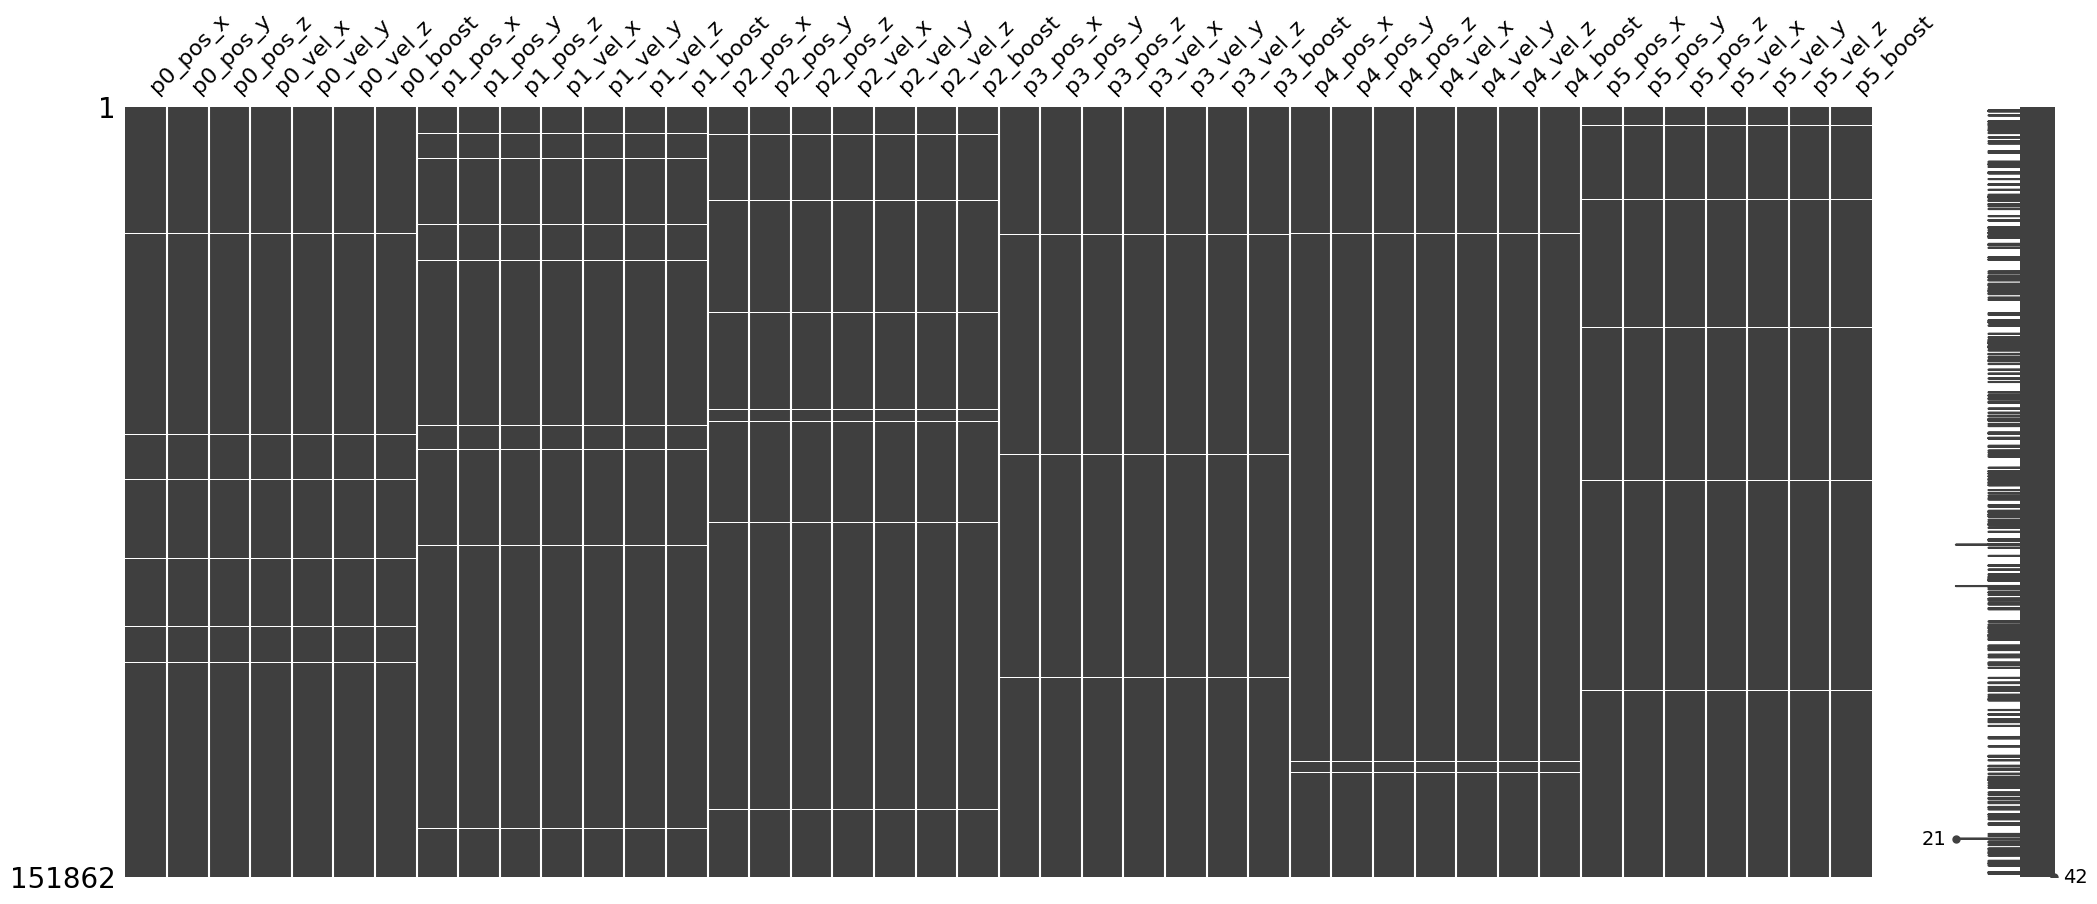

In [15]:
msno.matrix(X_train[player_features].sample(frac=0.1, random_state=777));

#### 4.1.1 Player Demolished

In [16]:
class PlayerDemolished(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.feature_names_out = []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_trans = X.copy()
        
        for i in range(1, 6):
            self.feature_names_out += [f"p{i}_demolished"]
            player_features = X_trans.columns[X_trans.columns.str.startswith(f"p{i}_")]
            X_trans[self.feature_names_out[-1]] = X_trans[player_features].isna().all(axis=1).astype(int)

        return X_trans[self.feature_names_out]

    # TODO: Improve this method
    def get_feature_names_out(self, input_features=None):
        # input_features = _check_feature_names_in(self, input_features)
        return asarray(self.feature_names_out, dtype=object)

### 4.3 Distance from the ball to the goal post

In [17]:
# Check Mahdee's discussion for more details about the goal post
# Source: https://www.kaggle.com/competitions/tabular-playground-series-oct-2022/discussion/357633
GOAL_POST1 = (0.0, -100.0, 6.8)
GOAL_POST2 = (0.0, 100.0, 6.8)

In [18]:
# TODO: Another implementation (using FunctionTransformer) can be found here:
# https://github.com/scikit-learn/scikit-learn/discussions/23992

class DistanceBallGoalPosts(BaseEstimator, TransformerMixin):

    def __init__(self, posts):
        self.posts = posts
        self.feature_names_out = []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_trans = X.copy()        
        for i, post in enumerate(self.posts, start=1):
            self.feature_names_out += [f"ball_distance_to_post{i}"]
            ball_position = ["ball_pos_x", "ball_pos_y", "ball_pos_z"]
            X_trans[self.feature_names_out[-1]] = X_trans[ball_position].sub(post).pow(2).sum(axis=1).pow(0.5)

        return X_trans[self.feature_names_out]

    # TODO: Improve this method for all custom transformers
    def get_feature_names_out(self, input_features=None):
        return asarray(self.feature_names_out, dtype=object)

### 4.4 Ball speed from velocity vector

In [19]:
class BallSpeed(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.feature_names_out = []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_trans = X.copy()        
        self.feature_names_out += ["ball_speed"]
        X_trans[self.feature_names_out[-1]] = X_trans.pow(2).sum(axis=1).pow(0.5)

        return X_trans[self.feature_names_out]

    def get_feature_names_out(self, input_features=None):
        return asarray(self.feature_names_out, dtype=object)

### 4.5 Player speed from velocity vector

In [20]:
class PlayerSpeed(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.feature_names_out = []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

        X_trans = X.copy()
        for i in range(6):
            self.feature_names_out += [f"p{i}_speed"]
            velocity_vector = [v for v in X_trans.columns if v.startswith(f"p{i}")]
            X_trans[self.feature_names_out[-1]] = X_trans[velocity_vector].pow(2).sum(axis=1).pow(0.5)

        return X_trans[self.feature_names_out]

    def get_feature_names_out(self, input_features=None):
        return asarray(self.feature_names_out, dtype=object)

## 5. Pipeline Building

In [21]:
# https://datascience.stackexchange.com/questions/73782/what-is-the-point-of-using-missingindicator-in-scikit-learn
players_features = ColumnTransformer(
    transformers=[
        ("player_demolished", PlayerDemolished(), selector(pattern="p[0-5]_")),
        ("player_imputer", SimpleImputer(strategy="constant", fill_value=0.0), selector(pattern="p[0-5]_")),
        ("player_speed", PlayerSpeed(), selector(pattern="p[0-5]_vel")),
        ], 
    n_jobs=-1,
    # remainder="passthrough",
    # verbose_feature_names_out=False,
)

In [22]:
ball_features = ColumnTransformer(
    transformers=[
        ("ball_speed", BallSpeed(), selector(pattern="ball_vel")),
        ("ball_distance_to_goal_posts", DistanceBallGoalPosts(posts=[GOAL_POST1, GOAL_POST2]), selector(pattern="ball_pos")),
        ], 
    # remainder="passthrough",
    # verbose_feature_names_out=True,
)

In [23]:
preprocessing = FeatureUnion(
    transformer_list = [
    ("players_features", players_features),
    ("ball_features", ball_features),
    ],
    verbose=True,
)

In [24]:
from sklearn.feature_selection import VarianceThreshold
pipe = Pipeline(
    steps=[
        ("preprocessing", preprocessing),
        # ("variance_threshold", VarianceThreshold()),
        ]
    )

In [25]:
pipe

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('players_features',
                                                 ColumnTransformer(n_jobs=-1,
                                                                   transformers=[('player_demolished',
                                                                                  PlayerDemolished(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7efccc8042e0>),
                                                                                 ('player_imputer',
                                                                                  SimpleImputer(fill_value=0.0,
                                                                                                strategy='constant'),
                                                                                  <sklearn.compose._column_transform...
                                                ('ball_features',
                                                 ColumnTransformer(transformers=[('ball_speed',
                                                                                  BallSpeed(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7efccc804400>),
                                                                                 ('ball_distance_to_goal_posts',
                                                                                  DistanceBallGoalPosts(posts=[(0.0,
                                                                                                                -100.0,
                                                                                                                6.8),
                                                                                                               (0.0,
                                                                                                                100.0,
                                                                                                                6.8)]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7efccc804e80>)]))],
                              verbose=True))])

## 6. Pipeline Fit-Tansform

In [26]:
X_trans = DataFrame(pipe.fit_transform(X_train), columns=pipe.get_feature_names_out())

[FeatureUnion]  (step 1 of 2) Processing players_features, total=   8.4s
[FeatureUnion] . (step 2 of 2) Processing ball_features, total=   0.6s
